# Data Mining Homework 2

In [23]:
from datetime import datetime
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.cluster import KMeans

from sklearn.cross_validation import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_curve, confusion_matrix)

%matplotlib inline

In [2]:
TRAIN_TEST_RATIO = 0.7
RANDSEED = int(datetime.now().timestamp())

In [3]:
df = pd.read_excel('./default of credit card clients.xls', header=1)

## Problem 1
Split the data randomly to training data and test data ( 70% / 30% )

In [4]:
df_train, df_test = train_test_split(df,
                                     train_size=TRAIN_TEST_RATIO,
                                     random_state=RANDSEED)

sr_train_id = df_train.pop("ID")
sr_train_y = df_train.pop("default payment next month")

sr_test_id = df_test.pop("ID")
sr_test_y = df_test.pop("default payment next month")

In [16]:
df_train.shape

(21000, 23)

In [17]:
df_test.shape

(9000, 23)

## Problem 2
What is the accuracy of (1) Logistic Regression (2) k-Nearest Neighbors
(3) Naive Bayes (4) Random Forest (5) SVM model in test data

In [7]:
clfs = [
    (LogisticRegression(), "Logistic Regression"),
    (KNeighborsClassifier(), "k-Nearest Neighbors"),
    (GaussianNB(), "Naive Bayes"),
    (RandomForestClassifier(), "Random Forest"),
    (SVC(), "SVM")
]
LR = 0
KNN = 1
NB = 2
RF = 3
SVM = 4

In [8]:
df_acy = pd.DataFrame(columns=["Method", "Accuracy"])

predicted_result_to = []

for clf, name in clfs:
    clf.fit(df_train, sr_train_y)
    predicted = clf.predict(df_test)
    df_acy = df_acy.append([
            {
                "Method": name,
                "Accuracy": accuracy_score(sr_test_y, predicted)
            }],ignore_index=True)
    predicted_result_to.append(predicted)
df_acy

,Method,Accuracy
0,Logistic Regression,0.780889
1,k-Nearest Neighbors,0.753000
2,Naive Bayes,0.373444
3,Random Forest,0.805444
4,SVM,0.781667


## Problem 3
Draw the ROC curve in Logistic Regression

In [9]:
logreg = clfs[LR][0]
score = logreg.decision_function(df_test)
fpr, tpr, thresholds = roc_curve(sr_test_y, score)

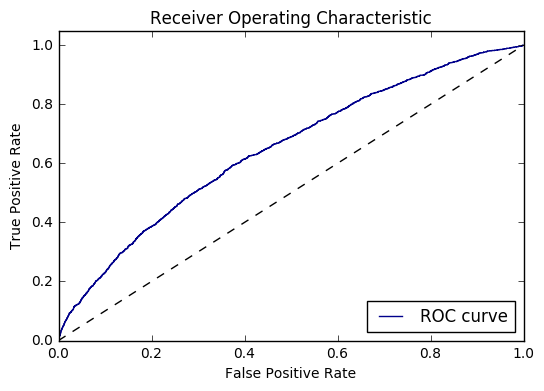

In [10]:
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=1, label="ROC curve")
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Problem 4
Calculate the precision and recall in k-Nearest Neighbors

In [11]:
print ("Precision Score : {0:.5f}".format(
        precision_score(
            sr_test_y,
            predicted_result_to[KNN]
        )))
print ("Recall    Score : {0:.5f}".format(
        recall_score(
            sr_test_y,
            predicted_result_to[KNN]
        )))

Precision Score : 0.37623
Recall    Score : 0.19432


## Problem 5
Draw the Confusion Matrix of Naive Bayes

In [12]:
pd.DataFrame(
    confusion_matrix(
        sr_test_y,
        predicted_result_to[NB]
    ))

,0,1
0,1627,5402
1,237,1734


## Problem 6
What is the performance with different parameters in SVM

In [13]:
def rand_svm_param(**kwargs):
    params = {
        'C': random.random(),
        'kernel': random.choice(['rbf','linear','poly','sigmoid']),
        'degree': random.randint(1,3),
        'coef0': random.random(),
        'probability': random.choice([True, False]),
        'shrinking': random.choice([True, False]),
        'decision_function_shape': random.choice(['ovo','ovr',None]),
        'random_state': int(datetime.now().timestamp())
    }
    params.update(kwargs)
    return params

In [14]:
SIZE = 4
diff_svm_params = [rand_svm_param() for _ in range(SIZE)]
clfs = [SVC(**diff_svm_params[i]) for i in range(SIZE)]
predicts = [None for _ in range(SIZE)]

In [15]:
def fit_SVC(order):
    clfs[order].fit(df_train, sr_train_y)
    return

In [ ]:
from threading import Thread

tasks = []

for i in range(SIZE):
    t = Thread(target=fit_SVC, args=(i,))
    t.start()
    tasks.append(t)

for t in tasks:
    t.join()

for i, clf in enumerate(clfs):
    predicts[i] = clf.predict(df_test)

In [ ]:
# Perform data
pd.DataFrame(
    data= {
        'kernel': [parm['kernel'] for parm in diff_svm_params],
        'C': [parm['C'] for parm in diff_svm_params],
        'degree': [parm['degree'] for parm in diff_svm_params],
        'coef0': [parm['coef0'] for parm in diff_svm_params],
        'probability': [parm['probability'] for parm in diff_svm_params],
        'shrinking': [parm['shrinking'] for parm in diff_svm_params],
        'decision_function_shape': [parm['decision_function_shape'] for parm in diff_svm_params],
        'random_state': [parm['random_state'] for parm in diff_svm_params],
        'Accuracy': [accuracy_score(p,sr_test_y) for p in  predicts]
    },
    columns= ['kernel','C','degree','coef0','probability','shrinking','decision_function_shape','random_state','Accuracy']
)

## Problem 7
According to Gender, Education, and Marital status, how many kinds of
customer should be divided into?

In [41]:
def elbow_method(df, n):
    kMeansVar = [KMeans(n_clusters=k).fit(df.values) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df.values)**2)/df.values.shape[0]
    bss = tss - wcss
    plt.title("Elbow method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Variance explained")
    plt.grid(True)
    plt.plot(bss, marker='o')
    plt.show()

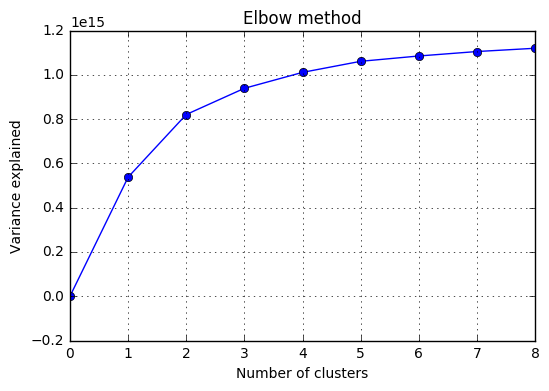

In [42]:
elbow_method(df, 10)